## Sugarscape
from ch. 11 Agent-Based Models in [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [92]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from Cell2D import Cell2D, draw_array
from utils import decorate, three_frame

## The Agent

In sugarscape, there are free-roving agents who harvest resources (sugar) from the environment (a Cell2D grid).

In [93]:
class Agent:
    max_vision=6
    max_metabolism=4
    lifespan_range=(10000, 10000)
    initial_sugar_range=(5, 25)

    def __init__(self, loc, vision=None, metabolism=None):
        """Creates a new agent at the given location.
        
        loc: (x,y) tuple coordinate
        params: dictionary of parameters
        """
        self.loc = tuple(loc)
        self.age = 0

        # choose attributes
        self.vision = vision or np.random.randint(1, self.max_vision+1)
        self.metabolism = metabolism or np.random.uniform(1, self.max_metabolism)
        self.lifespan = np.random.uniform(*self.lifespan_range)
        self.sugar = np.random.uniform(*self.initial_sugar_range)

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = env.look_and_move(self.loc, self.vision)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

## Sugarscape 2D grid

Defines the "landscape" of resources (sugar) the agents move around on and consume


In [58]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, num_agents=400, starting_box=None, **params):
        """Initializes the attributes.

        n: number of rows and columns
        params: dictionary of parameters
        """
        self.n = n
        self.params = params

        # track variables
        self.agent_count_seq = []

        # make the capacity array  (constant - capacity never changes)
        self.capacity = self._make_capacity()

        # initially all cells are at capacity (dynamic state of resource at each loc)
        self.array = self.capacity.copy()

        # make the agents
        starting_box = starting_box or self.array.shape
        self.agents = self._make_agents(num_agents, starting_box)
        # keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)


    def _make_capacity(self):
        """Makes the capacity array."""

        # compute the distance of each cell from the peaks.
        dist1 = distances_from(self.n, 15, 15)
        dist2 = distances_from(self.n, 35, 35)
        dist = np.minimum(dist1, dist2)

        # cells in the capacity array are set according to dist from peak
        bins = [21, 16, 11, 6]
        a = np.digitize(dist, bins)
        return a

    def _make_agents(self, num_agents, starting_box):
        """ Return a list of agents """

        # determine where the agents start and generate locations
        n, m = starting_box
        locs = make_locs(n, m)
        np.random.shuffle(locs)

        # make the agents
        num_agents = num_agents
        assert(num_agents <= len(locs))
        return [Agent(locs[i]) for i in range(num_agents)]

    def grow(self):
        """Adds sugar to all cells and caps them by capacity."""
        grow_rate = self.params.get('grow_rate', 1)
        self.array = np.minimum(self.array + grow_rate, self.capacity)

    def look_and_move(self, center, vision):
        """Finds the visible cell with the most sugar.

        center: tuple, coordinates of the center cell
        vision: int, maximum visible distance

        returns: tuple, coordinates of best cell
        """
        # find all visible cells
        locs = make_visible_locs(vision)
        locs = (locs + center) % self.n

        # convert rows of the array to tuples
        locs = [tuple(loc) for loc in locs]

        # select unoccupied cells
        empty_locs = [loc for loc in locs if loc not in self.occupied]

        # if all visible cells are occupied, stay put
        if len(empty_locs) == 0:
            return center

        # look up the sugar level in each cell
        t = [self.array[loc] for loc in empty_locs]

        # find the best one and return it
        # (in case of tie, argmax returns the first, which
        # is the closest)
        i = np.argmax(t)
        return empty_locs[i]

    def harvest(self, loc):
        """Removes and returns the sugar from `loc`.

        loc: tuple coordinates
        """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """Executes one time step."""
        replace = self.params.get('replace', False)

        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:

            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)

            # execute one step
            agent.step(self)

            # if the agent is dead, remove from the list
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if replace:
                    self.add_agent()
            else:
                # otherwise mark its cell occupied
                self.occupied.add(agent.loc)

        # update the time series
        self.agent_count_seq.append(len(self.agents))

        # grow back some sugar
        self.grow()
        return len(self.agents)

    def add_agent(self):
        """Generates a new random agent.

        returns: new Agent
        """
        new_agent = Agent(self.random_loc(), self.params)
        self.agents.append(new_agent)
        self.occupied.add(new_agent.loc)
        return new_agent

    def random_loc(self):
        """Choose a random unoccupied cell.

        returns: tuple coordinates
        """
        while True:
            loc = tuple(np.random.randint(self.n, size=2))
            if loc not in self.occupied:
                return loc

    def draw(self):
        """Draws the cells."""
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')

        # draw the agents
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

`make_locs` takes the dimensions of the grid and returns an array where each row is a coordinate in the grid.

In [51]:
def make_locs(n, m):
    """Makes array where each row is an index in an `n` by `m` grid.

    n: int number of rows
    m: int number of cols

    returns: NumPy array
    """
    t = [(i, j) for i in range(n) for j in range(m)]
    return np.array(t)

In [52]:
make_locs(2, 3)

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2]])

`make_visible_locs` takes the range of an agents vision and returns an array where each row is the coordinate of a visible cell.

The cells are at increasing distances.  The cells at each distance are shuffled.

In [53]:
def make_visible_locs(vision):
    """Computes the kernel of visible cells.

    vision: int distance
    """
    def make_array(d):
        """Generates visible cells with increasing distance."""
        a = np.array([[-d, 0], [d, 0], [0, -d], [0, d]])
        np.random.shuffle(a)
        return a

    arrays = [make_array(d) for d in range(1, vision+1)]
    return np.vstack(arrays)

In [54]:
make_visible_locs(2)

array([[ 0, -1],
       [-1,  0],
       [ 0,  1],
       [ 1,  0],
       [ 2,  0],
       [ 0,  2],
       [ 0, -2],
       [-2,  0]])

`distances_from` returns an array that contains the distance of each cell from the given coordinates.

In [55]:
def distances_from(n, i, j):
    """Computes an array of distances.

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

In [56]:
dist = distances_from(5, 2, 2)
dist

array([[2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.        , 1.        , 0.        , 1.        , 2.        ],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712]])

I use `np.digitize` to set the capacity in each cell according to the distance from the peak.  Here's an example that shows how it works.

In [57]:
bins = [3, 2, 1, 0]
np.digitize(dist, bins)

array([[1, 1, 1, 1, 1],
       [1, 2, 2, 2, 1],
       [1, 2, 3, 2, 1],
       [1, 2, 2, 2, 1],
       [1, 1, 1, 1, 1]])

Here's my implementation of Sugarscape:

Here's my implementation of the agents.

Here's an example with `n=50`, starting with 400 agents.

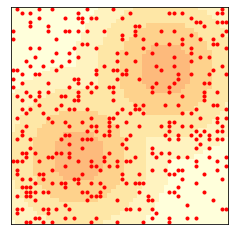

In [100]:
env = Sugarscape(50, num_agents=400)
env.draw()

The distribution of vision is uniform from 1 to 6.

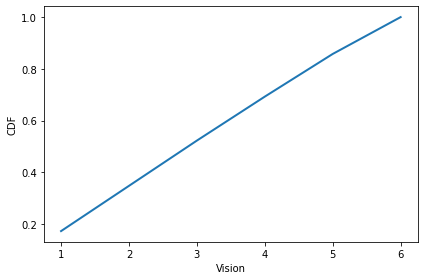

In [61]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(agent.vision for agent in env.agents)
cdf.plot()
decorate(xlabel='Vision', ylabel='CDF')

The distribution of metabolism is uniform from 1 to 4.

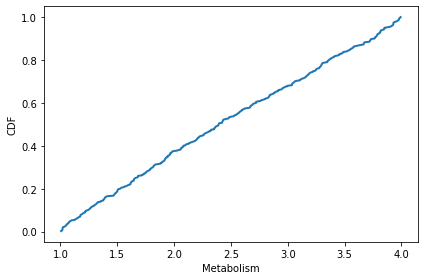

In [62]:
cdf = Cdf.from_seq(agent.metabolism for agent in env.agents)
cdf.plot()
decorate(xlabel='Metabolism', ylabel='CDF')

The distribution of initial endowment of sugar is uniform from 5 to 25.

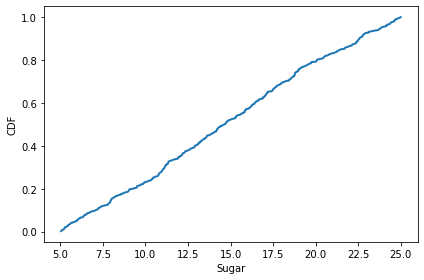

In [63]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Sugar', ylabel='CDF')

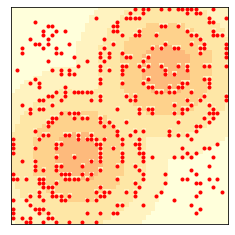

In [64]:
env.step()
env.draw()

Here's what the animation looks like.

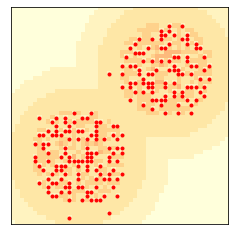

In [105]:
env.animate(frames=50)

The number of agents levels off at the "carrying capacity":

In [102]:
len(env.agents)

243

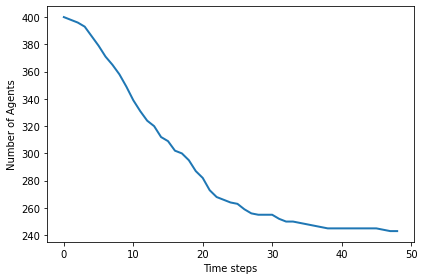

In [103]:
plt.plot(env.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Number of Agents')

This figure shows the state of the system after 2 and 10 steps.

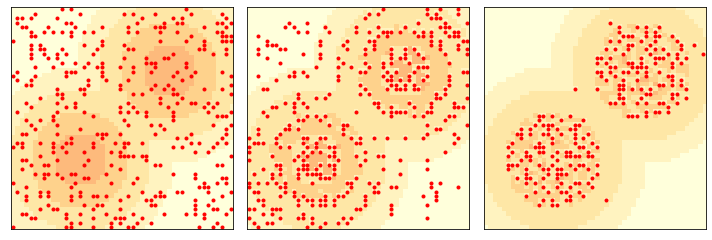

In [68]:
env = Sugarscape(50, num_agents=400)
three_frame(env, [0, 2, 98])

plt.show('figs/chap10-3')

**Exercise:** Experiment with different numbers of agents.  Try increasing or decreasing their vision or metabolism, and see what effect is has on carrying capacity.

## Sugarscape with finite lifespans

Now we start with 250 agents, with lifetimes from 60 to 100, and replacement.

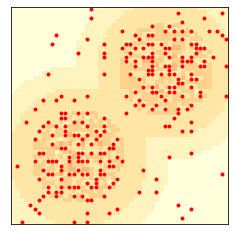

In [96]:
env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

env.animate(frames=100)

After 100 time steps, the distribution of wealth is skewed to the right.  Most agents have very little sugar, but a few have a lot.

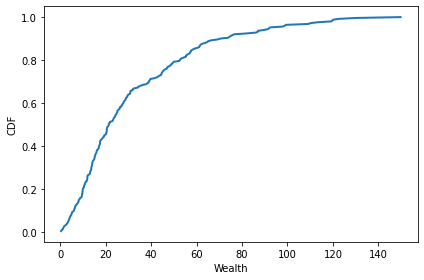

In [70]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

In [71]:
cdf.quantile([0.25, 0.50, 0.75, 0.90])

array([11.89267529, 21.33954204, 45.56741747, 70.40262877])

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [72]:
np.random.seed(17)

env = Sugarscape(50, num_agents=250,
                 min_lifespan=60, max_lifespan=100, 
                 replace=True)

cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]
for i in range(5):
    env.loop(100)
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

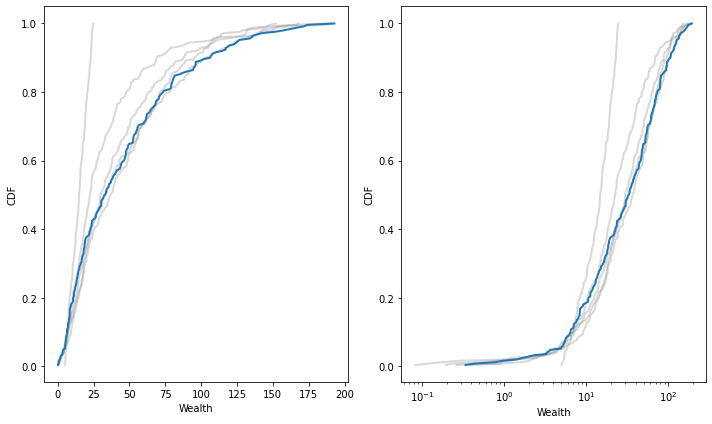

In [73]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF')

plt.subplot(1, 2, 2)
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF', xscale='log')

plt.show('figs/chap10-4')

**Exercise:** Experiment with different starting conditions and agents with different vision, metabolism, and lifespan.  What effect do these changes have on the distribution of wealth?

## Migration in waves

If we start with all agents in the lower left, they propagate up and to the right in waves.

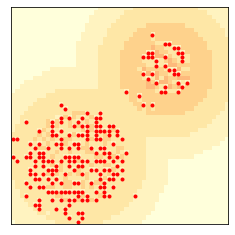

In [74]:
np.random.seed(17)

env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
    
env.animate(frames=20, interval=0.4)

Here's what it looks like after 6 and 12 steps.

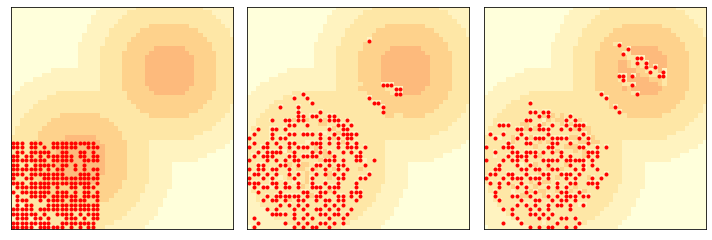

In [75]:
env = Sugarscape(50, num_agents=300, starting_box=(20, 20), max_vision=16)
three_frame(env, [0, 6, 6])
plt.show('figs/chap09-5')

This example is interesting because the waves move diagonally, unlike the agents, who can only move up or to the right.  They are similar in some ways to gliders and other Game of Life spaceships. 

**Exercise:** Again, experiment with different starting conditions and see what effect they have on the wave behavior.

## Exercises

**Exercise:** Bill Bishop, author of *The Big Sort*, argues that
American society is increasingly segregated by political
opinion, as people choose to live among like-minded neighbors.

The mechanism Bishop hypothesizes is not that people, like the agents
in Schelling's model, are more likely to move if they are
isolated, but that when they move for any reason, they are
likely to choose a neighborhood with people like themselves.

Write a version of Schelling's model to simulate
this kind of behavior and see if it yields similar degrees of
segregation.

There are several ways you can model Bishop's hypothesis.  In my
implementation, a random selection of agents moves during each step.
Each agent considers `k` randomly-chosen empty locations and
chooses the one with the highest fraction of similar neighbors.
How does the degree of segregation depend on `k`?

You should be able to implement this model by inheriting from
`Schelling` and overriding `__init__` and `step`.



In [76]:
# Solution goes here

In [77]:
# Solution goes here

And a test of the `step` method

In [78]:
# Solution goes here

In [79]:
# Solution goes here

In [80]:
# Solution goes here

In [81]:
# Solution goes here

**Exercise:** In the first version of Sugarscape, we never add agents, so once the population falls, it never recovers.  In the second version, we only replace agents when they die, so the population is constant.  Now let's see what happens if we add some "population pressure".

Write a version of Sugarscape that adds a new agent at the end of every step.  Add code to compute the average vision and the average metabolism of the agents at the end of each step.  Run the model for a few hundred steps and plot the population over time, as well as the average vision and average metabolism.

You should be able to implement this model by inheriting from
`Sugarscape` and overriding `__init__` and `step`.

In [82]:
# Solution goes here

In [83]:
# Solution goes here

In [84]:
# Solution goes here

In [85]:
# Solution goes here

In [86]:
# Solution goes here

In [87]:
# Solution goes here

In [88]:
# Solution goes here

In [89]:
# Solution goes here

In [90]:
# Solution goes here

In [91]:
# Solution goes here